# ResNet in MNIST Dataset

In [0]:
import numpy as np                  # for working with tensors outside the network
import pandas as pd                 # for data reading and writing
import matplotlib.pyplot as plt  

In [2]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [0]:
def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

# Model definition in tensorflow

In [0]:
input_tensor = Input((28, 28, 1))

# first conv2d with post-activation to transform the input data to some reasonable form
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = BatchNormalization()(x)
x = Activation(relu)(x)

# F_1
x = block(16)(x)
# F_2
x = block(16)(x)

x = BatchNormalization()(x)
x = Activation(relu)(x)

# average pooling across the channels
# 28x28x48 -> 1x48
x = GlobalAveragePooling2D()(x)

# dropout for more robust learning
x = Dropout(0.2)(x)

# last softmax layer
x = Dense(units=10, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation(softmax)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
df_train = pd.read_csv('train.csv')
print(df_train.shape)

df_train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:

y_train_ = df_train['label'].values.astype(np.int).reshape(-1, 1)
x_train = df_train.iloc[:, 1:].values.astype(np.float32).reshape((-1, 28, 28, 1))

In [0]:
df_test = pd.read_csv('test.csv')

x_test = df_test.values.astype(np.float32).reshape((-1, 28, 28, 1))

In [0]:
y_train = OneHotEncoder(sparse=False).fit_transform(y_train_)


In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train_)

In [0]:
m = x_train.mean(axis=0)

x_train -= m
x_val -= m
x_test -= m

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [0]:
mc = ModelCheckpoint('weights.best.keras', monitor='val_acc', save_best_only=True)

In [0]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    
    if e > end:
        return lr_end
    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

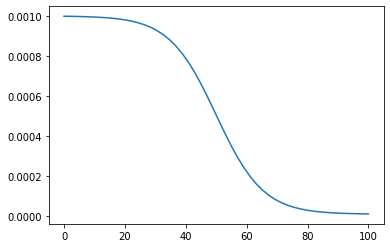

In [0]:
xs = np.linspace(0, 100)
ys = np.vectorize(sigmoidal_decay)(xs)
plt.plot(xs, ys)
plt.show()

In [0]:
EPOCHS = 10  


In [0]:
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS))

In [0]:
hist = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=512, callbacks=[lr, mc])

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 83s 2ms/step - loss: 1.9937 - accuracy: 0.3972 - val_loss: 2.3022 - val_accuracy: 0.3860
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


33600/33600 [==============================] - 79s 2ms/step - loss: 1.8653 - accuracy: 0.4567 - val_loss: 2.2563 - val_accuracy: 0.3849
Epoch 3/10
33600/33600 [==============================] - 80s 2ms/step - loss: 1.7650 - accuracy: 0.5130 - val_loss: 2.1696 - val_accuracy: 0.3800
Epoch 4/10
33600/33600 [==============================] - 80s 2ms/step - loss: 1.6850 - accuracy: 0.5534 - val_loss: 2.0118 - val_accuracy: 0.4892
Epoch 5/10
33600/33600 [==============================] - 79s 2ms/step - loss: 1.6222 - accuracy: 0.5808 - val_loss: 1.8943 - val_accuracy: 0.5367
Epoch 6/10
33600/33600 [==============================] - 79s 2ms/step - loss: 1.5718 - accuracy: 0.6064 - val_loss: 1.7206 - val_accuracy: 0.6905
Epoch 7/10
33600/33600 [==============================] - 79s 2ms/step - loss: 1.5435 - accuracy: 0.6186 - val_loss: 1.6080 - val_accuracy: 0.7549
Epoch 8/10
33600/33600 [==============================] - 79s 2ms/step - loss: 1.5362 - accuracy: 0.6294 - val_loss: 1.5297 - val

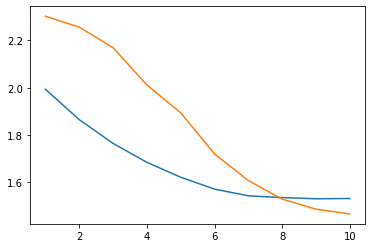

In [0]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = np.arange(1, EPOCHS + 1)

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.show()

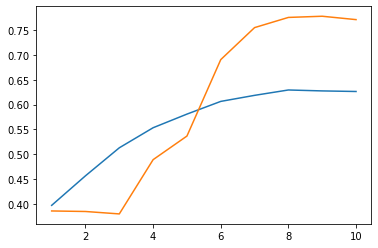

In [0]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = np.arange(1, EPOCHS + 1)

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.show()

In [0]:
p_test = model.predict(x_test, batch_size=512)
p_test = np.argmax(p_test, axis=1)
p_test

array([2, 0, 9, ..., 3, 9, 2])